Let’s work on the following:
1. Access the CB API (with my login info), which is inside Dropbox. Download the list of companies founded in 2016 and with category ‘Artificial Intelligence’. That should be 500sh companies, we start with a small sample.
2. For each of those companies, download all the NEWS that Crunchbase has. Try to put those news into an easy format: maybe a TXT file per news, and all TXT files of a company into one folder. And remove all non-relevant components (like Ads or other text). This will make it easier if somebody in the team will have to do some reading.
3. Once this looks good, we’ll do some NLP on the text. But let’s get the "raw data" first.
4. Please upload all material on Dropbox.

In [1]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import nltk
from nltk import *
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import sys
import codecs
import string
import random
import re

import requests
import urllib
import bs4
from bs4 import BeautifulSoup
from readability.readability import Document # https://github.com/buriy/python-readability. Tried Goose, Newspaper (python libraries on Github). Bad results.
from http.cookiejar import CookieJar # 

import time
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates

import ast
from itertools import chain
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
import shutil

import articleDateExtractor
from newspaper import Article

import pycrunchbase
cb = pycrunchbase.CrunchBase('662e263576fe3e4ea5991edfbcfb9883')

/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
Using TensorFlow backend.


In [ ]:
# df = pd.DataFrame(columns=["permalink"])

# url = 'https://api.crunchbase.com/v3.1/organizations/?user_key=662e263576fe3e4ea5991edfbcfb9883'
# # location given here 
# location = "philadephia"

# # defining a params dict for the parameters to be sent to the API 
# PARAMS = {'address':location} 

# while True:
#     try:
#         response = requests.get(url, PARAMS)
#         json = response.json()
#         for c in json['data']['items']:
#             permalink=c['properties']['permalink']
#             if(permalink!=None):
#                 categories_json = requests.get("https://api.crunchbase.com/v3.1/organizations/" 
#                                 + permalink+"/categories?user_key=662e263576fe3e4ea5991edfbcfb9883", PARAMS).json()
#                 for cat in categories_json['data']['items']:
#                     if(cat["properties"]["category_groups"]!=None):
#                         if("Artificial Intelligence" in cat["properties"]["category_groups"]):
#                             print(permalink)
#                             df = df.append({'permalink' : permalink} , ignore_index=True)
#         url = json['data']['paging']['next_page_url'] + "&user_key=662e263576fe3e4ea5991edfbcfb9883"
#         print(url)
#     except:
#         print("error: " + url)
        
# df

df = pd.read_csv('csv_export/organizations.csv')
print(df.columns)
df

In [ ]:
ai_df = pd.DataFrame(columns = df.columns)
for i in range(len(df)):
    try:
        if("Artificial Intelligence" in df['category_group_list'][i] and '2016' in df['founded_on'][i]):
            ai_df = ai_df.append(df.loc[i])
    except:
        pass
ai_df

In [ ]:
ai_df= ai_df.reset_index(drop=True)
ai_df

In [ ]:
# location given here 
location = "philadephia"

# defining a params dict for the parameters to be sent to the API 
PARAMS = {'address':location} 
for i in range(len(ai_df)):
    permalink = ai_df['permalink'][i].split("/")[2]
    newpath = '/Users/ksun/downloads/startup-data/ai-organizations/' + permalink
    if not os.path.exists(newpath):
        print("create new folder", newpath)
        os.makedirs(newpath)
    
        url = 'https://api.crunchbase.com/v3.1/organizations/' + permalink+'?relationships=news&user_key=662e263576fe3e4ea5991edfbcfb9883'
        response_json = requests.get(url, PARAMS).json()

        for n in response_json['data']['relationships']['news']['items']:
            try:
                uri=n['properties']['url']
                opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor)
                opener.addheaders = [('User-agent', 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/535.7 (KHTML, like Gecko) Chrome/16.0.912.77 Safari/535.7')]
                html =  opener.open(uri).read().decode('utf-8')
                readable_article = Document(html).summary()
                soup = BeautifulSoup(readable_article, "lxml")
                text = soup.get_text()

                name_of_file = uri.replace(".", "-").replace(":", "-").replace("/", "-")
                path = newpath + "/"

                completeName = os.path.join(path, name_of_file+".txt")  


                file1 = open(completeName, "w")

                file1.write(text)

                file1.close()
            except:
                pass
            
    if len(os.listdir(newpath)) == 0:
        print(newpath)
    
        url = 'https://api.crunchbase.com/v3.1/organizations/' + permalink+'?relationships=news&user_key=662e263576fe3e4ea5991edfbcfb9883'
        response_json = requests.get(url, PARAMS).json()
        print(url)

        for n in response_json['data']['relationships']['news']['items']:
            try:
                uri=n['properties']['url']
                print(uri)
                opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor)
                opener.addheaders = [('User-agent', 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/535.7 (KHTML, like Gecko) Chrome/16.0.912.77 Safari/535.7')]
                html =  opener.open(uri).read().decode('utf-8')
                readable_article = Document(html).summary()
                soup = BeautifulSoup(readable_article, "lxml")
                text = soup.get_text()

                name_of_file = uri.replace(".", "-").replace(":", "-").replace("/", "-")
                path = newpath + "/"

                completeName = os.path.join(path, name_of_file+".txt")  


                file1 = open(completeName, "w")

                file1.write(text)
                if(len(text) != 0):
                    print("write complete:", newpath)

                file1.close()
            except:
                pass


Hi Kevin
Thanks again for coming in! And great job – this is an excellent first step.
Here are the next steps:
1. I went through the folders – most look good, but it’s possible there’s some missing material. Spend a little more time to perfect the downloading  code. See if you can fix whichever errors you find through the process. It might be best to make this code as smooth as possible now, before we scale to working with lots of companies.
2. I am assuming the scraping process is OK, but it’s probably helpful to take one more look at that too (i.e. for example, those few lines missing in the TXT we looked at together may happen elsewhere too, no huge deal but worth looking into it).
3. Once you’ve finalized the downloading process, let’s start with a very simple exercise on the TXT files. For each TXT of each company, write a code that counts the number of times the following keywords are mentioned: PROTOTYPE, TEST, EXPERIMENT, MINIMUM VIABLE PRODUCT, BETA, ALPHA. This is just a start, we’ll do more of this, but let’s see how this goes. You can then input this data into an Excel file (one row per company).
 
If possible, please write your Python code clearly and upload it. So I can try to take a look.
 
Please remember to submit your timesheet by Thursday night each week. Let’s try to meet week after Spring break, I am very flexible. Of course, please reach out if you have any questions at any point.
Thanks so much!
A

In [ ]:
rootdir = '/Users/ksun/downloads/startup-data/ai-organizations/'

ai_df['articles'] = np.empty((len(ai_df), 0)).tolist()

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if '.DS_Store' not in file:
#             if(len(ai_df[ai_df['permalink'].astype(str).str.contains('/organization/' + subdir.split("/")[-1])])==0):
#                 print('/organization/' + subdir.split("/")[-1])
#                 shutil.rmtree(subdir)
#                 break
            row_index = ai_df.loc[ai_df['permalink'] == '/organization/' + subdir.split("/")[-1]].index.values.astype(int)[0]
            file = open(subdir +  "/" + file, "r")
            ai_df['articles'][row_index].append(file.read())
            file.close()

In [ ]:
# ai_df.to_csv('csv_export/ai_df.csv', index=False)

In [ ]:
# ai_df = pd.read_csv('csv_export/ai_df_old.csv', index_col=0)
# ai_df
# ai_df.drop(['Unnamed: 0'], axis=1)
# ai_df.to_csv('csv_export/ai_df.csv', index=False)

1. Gather good data from twitter (make sure to scrape over several months, stop at December 2018
2. topic clusters, sentiment, OVER TIME (month level) for a specific company
3. Take one old company like Google and track over time
__________________________
Let’s continue to work on the 2016 sample of AI companies for now, just to keep it simple.
1. Let’s add news from TWITTER and GOOGLE NEWS. You decide how to better get the right material from these two sources.
2. Once we have all these sources in place, we can start by doing a simple sentiment analysis. Each company should have a time series of sentiment measures (i.e. number of negative news): so each company should be have observations between first month of life and Dec 2018.

In [ ]:
# location given here 
location = "philadephia"

ai_df['articles'] = np.empty((len(ai_df), 0)).tolist()

# defining a params dict for the parameters to be sent to the API 
HEADERS = {'accept':"application/json"} 
for i in range(len(ai_df)):
    permalink = ai_df['permalink'][i].split("/")[2]
    
    url = 'https://api.crunchbase.com/v3.1/organizations/' + permalink+'?relationships=news&user_key=662e263576fe3e4ea5991edfbcfb9883'
    try:
        response_json = requests.get(url, headers=HEADERS, params={"$filter":"Path eq '/xxxxxx/'"}).json()
        print(url)

        for n in response_json['data']['relationships']['news']['items']:

            try:
                uri=n['properties']['url']
                opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor)
                opener.addheaders = [('User-agent', 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/535.7 (KHTML, like Gecko) Chrome/16.0.912.77 Safari/535.7')]
                html =  opener.open(uri).read().decode('utf-8')
                readable_article = Document(html).summary()
                soup = BeautifulSoup(readable_article, "lxml")
                text = soup.get_text()

    #             article = Article(uri)
    #             article.parse()
                date = n['properties']['posted_on']
    #             date = articleDateExtractor.extractArticlePublishedDate(uri)


                ai_df['articles'][i].append([uri, date, text])


            except:
                print("error:", permalink)
    except:
        print("error", url)
        #ugly-research
        #recomomenderx, geopipe-inc, cloudzero, ekkono-solutions, trials-ai, quali-fit, vidrovr, ar-cadia, ns8-inc, vapispace, satisfy, gravyty, ignite-biosciences

In [ ]:
count = 0
for i in range(len(ai_df)):
    if(len(ai_df['articles'][i])>10):
        count+=1
print(count)

Thanks for coming in, Kevin!
 
I think we’re doing great progress.
 
Here's the next steps of this  task:
1. Let’s focus on just 1 company and just Twitter. We should try to get all tweets from that company and about that company (from the very beginning to Dec 31st 2018).
2. Let’s allocate the tweets on each month from the month in which the Twitter account opens.
3. Let’s run sentiment analysis and graph sentiment over all months. You could probably do a separate graph for tweets from the company and tweets about the company. The graph should be a time series, where axis X is date and Y is sentiment. It should basically look like a curve that goes on over time.
4. To do this, pick a good company: one that has enough tweets.
5. If the process is not to heavy, let’s scale it to 100 companies. Just pick 100 companies from your sample.
 
You can take a look at how much it’d be to move the process to Amazon Web Services. Let me know how it looks and we can then decide.
 
If possible, please send me an update sometimes next week and then we can probably meet the week of Apr 8th. (No need to meet next week!)
 
Thanks again!
A

In [ ]:
ai_df['twitter_url'][142].split("/")[-2]

In [ ]:
#  python Exporter.py --username "viralheat" --since 2016-01-01 --until 2018-12-31
# python Exporter.py --username "kernelco" --since 2016-01-01 --until 2018-12-31 --maxtweets 100
# python main.py --username "kernelco" --since 2016-01-01 --until 2018-12-31 --max-tweets 1000000

In [ ]:
ai_df['num_prototype'] = 0
ai_df['num_test'] = 0
ai_df['num_experiment'] = 0
ai_df['num_minimum_viable_product'] = 0
ai_df['num_beta'] = 0
ai_df['num_alpha'] = 0
for i in range(len(ai_df)):
    wordlist = []
    for a in ai_df['articles'][i]:
        wordlist.extend(list(chain(*[word_tokenize(s) for s in sent_tokenize(a)])))
    counter = Counter(wordlist)
    ai_df.loc[i, 'num_prototype'] = counter['prototype']
    ai_df.loc[i, 'num_test'] = counter['test']
    ai_df.loc[i, 'num_experiment'] = counter['experiment']
    ai_df.loc[i, 'num_minimum_viable_product'] = counter['viable']
    ai_df.loc[i, 'num_beta'] = counter['beta']
    ai_df.loc[i, 'num_alpha'] = counter['alpha']

In [25]:
rootdir = '/Users/ksun/downloads/startup-data/GetOldTweets-python'

ai_df['tweets'][1050] = np.empty((len(ai_df), 0)).tolist()
ai_df['tweets'][983] = np.empty((len(ai_df), 0)).tolist()
ai_df['tweets'][599] = np.empty((len(ai_df), 0)).tolist()

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
#         if '.DS_Store' not in file and file in ['mobalytics-2.csv', 'swisscognitive.csv', 'prisma-5.csv']:
        if '.DS_Store' not in file and file in ['freightwaves.csv', 'element-ai.csv', 'matrix-foundation.csv']:
#             if(len(ai_df[ai_df['permalink'].astype(str).str.contains('/organization/' + subdir.split("/")[-1])])==0):
#                 print('/organization/' + subdir.split("/")[-1])
#                 shutil.rmtree(subdir)
#                 break
            row_index = ai_df.loc[ai_df['permalink'] == '/organization/' + file[0:-4]].index.values.astype(int)[0]
#             file = open(subdir +  "/" + file, "r")
            print(subdir +  "/" + file)
            temp_tweet_df = pd.read_csv(subdir +  "/" + file, error_bad_lines=False, sep=';')
            for j in range(len(temp_tweet_df)):
#                 try:
                ai_df['tweets'][row_index].append([str(temp_tweet_df['username'][j]),
                                                  temp_tweet_df['date'][j],
                                                  temp_tweet_df['retweets'][j],
                                                  temp_tweet_df['favorites'][j],
                                                  str(temp_tweet_df['text'][j])])
#                 except:
#                     continue
                    
# import shutil
# rootdir = '/Users/ksun/downloads/startup-data/Twitter-Get-Old-Tweets-Scraper/tweets'

# ai_df['tweets'] = np.empty((len(ai_df), 0)).tolist()

# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#         if '.DS_Store' not in file:
# #             if(len(ai_df[ai_df['permalink'].astype(str).str.contains('/organization/' + subdir.split("/")[-1])])==0):
# #                 print('/organization/' + subdir.split("/")[-1])
# #                 shutil.rmtree(subdir)
# #                 break
#             row_index = ai_df.loc[ai_df['permalink'] == '/organization/' + file.split("/")[-1][0:-4]].index.values.astype(int)[0]
# #             file = open(subdir +  "/" + file, "r")
#             print(subdir +  "/" + file)
#             temp_tweet_df = pd.read_csv(subdir +  "/" + file, error_bad_lines=False)
#             for j in range(len(temp_tweet_df)):
#                 try:
#                     ai_df['tweets'][row_index].append([str(temp_tweet_df['username'][j]),
#                                                       str(temp_tweet_df['user_handle'][j]),
#                                                       temp_tweet_df['date'][j],
#                                                       temp_tweet_df['retweets'][j],
#                                                       temp_tweet_df['favorites'][j],
#                                                       str(temp_tweet_df['text'][j])])
#                 except:
#                     continue

/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [2]:
# ai_df.to_csv('csv_export/ai_df.csv', index=False)
ai_df = pd.read_csv('csv_export/ai_df.csv')
ai_df
# ai_df.drop(['Unnamed: 0'], axis=1)
# ai_df.to_csv('csv_export/ai_df.csv', index=False)

,company_name,roles,permalink,domain,homepage_url,country_code,state_code,region,city,address,...,primary_role,type,articles,num_prototype,num_test,num_experiment,num_minimum_viable_product,num_beta,num_alpha,tweets
0,Ubiquity.ai,company,/organization/ubiquity-ai,ubiquity.ai,http://ubiquity.ai,NaN,NaN,NaN,NaN,NaN,...,company,organization,[],0,0,0,0,0,0,[]
1,Viralheat,"company,investor",/organization/viralheat,viralheat.com,http://www.viralheat.com,USA,CA,SF Bay Area,San Mateo,1510 Fashion Island Blvd. Ste. 260,...,company,organization,[['http://adexchanger.com/digital-marketing-2/...,0,0,0,0,0,0,[]
2,DealStart,company,/organization/dealstart,dealstart.com,https://dealstart.com,USA,NY,New York City,New York,"79 Madison Avenue, 7th Floor",...,company,organization,[],0,0,0,0,0,0,[]
3,UniQreate,company,/organization/uniqreate-limited,uniqreate.com,http://www.uniqreate.com,USA,NY,New York City,New York,"353 Lexington Avenue, Suite 1605",...,company,organization,[],0,0,0,0,0,0,[]
4,Really,company,/organization/really-really-inc,really.ai,https://really.ai/,USA,CA,SF Bay Area,Palo Alto,950 Page Mill Road,...,company,organization,[['https://www.bloomberg.com/view/articles/201...,0,0,0,0,0,0,[]
5,Flyreel,company,/organization/flyreel,flyreel.com,http://flyreel.com,USA,CO,Denver,Denver,3000 Lawrence Street,...,company,organization,[['https://www.prnewswire.com/news-releases/mi...,0,0,0,0,0,0,[]
6,DISCERN,company,/organization/discern,discern.com,http://www.discern.com,USA,CA,SF Bay Area,San Mateo,493 South El Camino Real,...,company,organization,[],0,0,0,0,0,0,[]
7,Polte Corporation,company,/organization/polte,polte.com,https://www.polte.com/,USA,TX,Dallas,Richardson,801 E. Campbell Road\nSuite 580\n,...,company,organization,[['https://techcrunch.com/2018/09/05/polte-let...,0,0,0,0,0,0,[]
8,ParallelM,company,/organization/parallel-machines,parallelm.com,http://www.parallelm.com,USA,CA,SF Bay Area,Sunnyvale,"1290 Oakmead Parkway, Suite #301",...,company,organization,[['https://www.businesswire.com/news/home/2019...,0,0,0,0,0,0,[]
9,Puttmee by Kausoft GmbH,company,/organization/kausoft-gmbh,puttmee.com,http://puttmee.com,DEU,NaN,Cologne,Cologne,Wiedstr. 8,...,company,organization,[],0,0,0,0,0,0,[]


In [3]:
def preprocessTweet(tweet): # preprocess tweets
    tweet = re.sub(r'\d+', '', str(tweet)) # remove numbers
    tweet = tweet.lower() # convert to lower case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # convert www.* or https?://* to URL
    tweet = re.sub('@[^\s]+','AT_USER',tweet) # convert @username to AT_USER
    tweet = re.sub('[\s]+', ' ', tweet) # remove additional white spaces
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) # replace #word (hashtags) with word
    tweet = tweet.strip('\'"') # trim
    return tweet    

def replaceTwoOrMore(s):
    #look for 2 or more repetitions of character and replace with the character itself
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", s)

preprocessTweet("@VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn")

"AT_USER AT_USER i'm flying your fabulous seductive skies again! u take all the stress away from travel URL"

In [5]:
def getStopWordList(stopWordListFileName): # get stopword list
    sw = [] # create list of stopwords
    
    nltk_stopwords = stopwords.words('english')
    for w in nltk_stopwords:
        sw.append(w)
    sw.append('AT_USER') # special stopwords from preprocessTweet function
    sw.append('URL')
    
    fp = open(stopWordListFileName, 'r') # load in any more custom stopwords from file
    line = fp.readline()
    while line:
        word = line.strip()
        sw.append(word)
        line = fp.readline()
    fp.close()
    return sw


stopword_list = getStopWordList('csv_export/stopwords.txt')
print('Stopword List: ', stopword_list)

Stopword List:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same',

In [ ]:
def getFeatureVector(tweet): 
    featureVector = []
    #split tweet into words
    words = tweet.split()
    for w in words:
        w = replaceTwoOrMore(w) # replace two or more with two occurrences
        w = w.strip('\'"?,.') # strip punctuation
        val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", w) # check if the word starts with an alphabet
        if(w in stopword_list or val is None): # ignore if it is a stop word
            continue
        else:
            featureVector.append(w.lower())
    return featureVector
 
getFeatureVector(preprocessTweet("@VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn"))

In [ ]:
airline_train = pd.read_csv("Twitter-Get-Old-Tweets-Scraper/training.1600000.processed.noemoticon.csv", 
                          header=None, encoding="ISO-8859-1") #latin1 encoding
airline_train.columns = ["sentiment", "id", "date", "query", "user", "text"]
# airline_train = airline_train.sample(frac=0.05, replace=True, random_state=1)
# airline_train = airline_train.reset_index(drop=True)
airline_tweets = []
airline_featurelist = []
for i in range(len(airline_train)):
    sentiment = airline_train['sentiment'][i]
    tweet = airline_train['text'][i]
    preprocessedTweet = preprocessTweet(tweet)
    featureVector = getFeatureVector(preprocessedTweet)
    airline_featurelist.extend(featureVector)
    airline_tweets.append((featureVector, sentiment))
        
def extract_features(tweet): # Determine if tweet contains a feature word
    tweet_words = set(tweet)
    features = {}
    for word in airline_featurelist:
        features['contains(%s)' % word] = (word in tweet_words)
    return features

airline_featurelist = list(set(airline_featurelist)) # remove airline_featurelist duplicates
airline_featurelist

In [ ]:
airline_training_set = nltk.classify.util.apply_features(extract_features, airline_tweets)
airline_NBClassifier = nltk.NaiveBayesClassifier.train(airline_training_set)

In [7]:
from sklearn.externals import joblib
# joblib.dump(airline_NBClassifier, 'csv_export/NBClassifier.pkl') 
# NBClassifier = joblib.load('csv_export/NBClassifier.pkl') 

In [8]:
# https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis
model = load_model('twitter-sentiment-model/model.h5')
tokenizer = joblib.load('twitter-sentiment-model/tokenizer.pkl') 

In [9]:
# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.5, 0.5)

def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score < SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [17]:
print(ai_df.loc[ai_df['permalink'] == '/organization/' + 'prisma-5'].index.values.astype(int)[0])
print(ai_df.loc[ai_df['permalink'] == '/organization/' + 'swisscognitive'].index.values.astype(int)[0])
print(ai_df.loc[ai_df['permalink'] == '/organization/' + 'mobalytics-2'].index.values.astype(int)[0])
print(ai_df.loc[ai_df['permalink'] == '/organization/' + 'freightwaves'].index.values.astype(int)[0])
print(ai_df.loc[ai_df['permalink'] == '/organization/' + 'element-ai'].index.values.astype(int)[0])
print(ai_df.loc[ai_df['permalink'] == '/organization/' + 'matrix-foundation'].index.values.astype(int)[0])

67
1893
814
1050
983
599


In [23]:
ast.literal_eval(str(ai_df['tweets'][1050]))

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [ ]:
# # for i in range(len(ai_df)):
# #     tweets = ast.literal_eval(ai_df['tweets'][1904])
# #     for t in tweets:
# #         t.append(NBClassifier.classify(extract_features(getFeatureVector(preprocessTweet(t[5])))))
# #     ai_df.loc[i, 'tweets'] = str(tweets)

# tweets = ast.literal_eval(str(ai_df['tweets'][67]))
# for t in tweets:
# #     try:
# #         del t[6]
# #     except:
# #         pass
#     s = predict(preprocessTweet(t[4]))['label']
#     t.append(s)
# ai_df.loc[67, 'tweets'] = str(tweets)
# tweets = ast.literal_eval(str(ai_df['tweets'][1893]))
# for t in tweets:
# #     try:
# #         del t[6]
# #     except:
# #         pass
#     s = predict(preprocessTweet(t[4]))['label']
#     t.append(s)
# ai_df.loc[1893, 'tweets'] = str(tweets)
# tweets = ast.literal_eval(str(ai_df['tweets'][814]))
# for t in tweets:
# #     try:
# #         del t[6]
# #     except:
# #         pass
#     s = predict(preprocessTweet(t[4]))['label']
#     t.append(s)
# ai_df.loc[814, 'tweets'] = str(tweets)
# ai_df

In [12]:
ai_df_vis = pd.DataFrame(columns=['permalink', 'day', 'negative_count', 'positive_count'])

checked_days = [] # keep track of which days we have already added to airline_data
for i in range(len(ai_df)):
    if i==814:
        tweets = ast.literal_eval(ai_df['tweets'][i])
        for j in range(len(tweets)):
            cur_date = str(datetime.datetime.strptime(tweets[j][1].split(" ")[0], '%Y-%m-%d').strftime('%Y-%m'))
            if cur_date not in checked_days:
                print(tweets[j][1])
                checked_days.append(cur_date)
                try:
                    temp = list(filter(lambda x: str(datetime.datetime.strptime(x[1].split(" ")[0], '%Y-%m-%d').strftime('%Y-%m')) == cur_date and x[0]== 'MobalyticsHQ', tweets))
                    print(temp)

                    neg = 0 # negative count
                    pos = 0 # positive count
                    for k in range(len(temp)):
                        if temp[k][5] == 'NEGATIVE':
                            neg += 1
                        elif temp[k][5] == 'POSITIVE':
                            pos += 1
                    temp_df = pd.DataFrame([[ai_df.loc[i, 'permalink'], cur_date, neg, pos]], columns=['permalink', 'day', 'negative_count', 'positive_count'])
                    print(temp_df) # keep track of progress
                    ai_df_vis = ai_df_vis.append(temp_df, ignore_index=True)
                except:
                    print("error", cur_date)

2018-12-30 17:45
[['MobalyticsHQ', '2018-12-29 13:22', 1, 6, "We have started and developed a really amazing process with everyone when it comes to the Mobalytics tier list. It wouldn't be possible without all your interesting and insightful questions and comments! Check out the latest 8.24 tier list Q&A here! https:// mobalytics.gg/blog/mobalytic s-patch-8-24b-tier-list-qa/ …", 'POSITIVE'], ['MobalyticsHQ', '2018-12-26 12:36', 2, 6, 'Hopefully everyone is enjoying their holidays (on and off the rift!) We’ve been seeing some requests recently from HoTS players that want to get into #Leagueoflegends and the holidays are the perfect time for this transition! https:// mobalytics.gg/blog/5-tips-fo r-hots-to-league/ …', 'POSITIVE'], ['MobalyticsHQ', '2018-12-21 17:26', 1, 4, 'Playing #leagueoflegends is fun but just like everything else, it is much funner with friends! If you want to get the most out of your duo queue experience, check one of our latest blog articles! https:// mobalytics.gg

[['MobalyticsHQ', '2018-10-31 20:13', 1, 1, 'Last time @PicklePantsLoL showed us the best way to play from behind in the bottom lane. With the importance of the jungle role in the current meta, it was only fitting that he graced us with his guide on playing from behind as a jungler! #junglemain https:// mobalytics.gg/blog/7-ways-to -play-from-behind-as-a-jungler/ …', 'NEGATIVE'], ['MobalyticsHQ', '2018-10-29 18:56', 0, 4, '#Worlds2018 semi finals were complete shutdowns and very impressive to watch. Now we know we are gonna have a legit clash of titans! In the mean time, check out our latest quick tips video ft the god of hooks himself, @Scrandor at https:// youtu.be/od5W-9XJCmo #leagueoflegends #itson pic.twitter.com/hjvqY7RbwZ', 'POSITIVE'], ['MobalyticsHQ', '2018-10-28 02:17', 1, 7, "Yesterdays games were quite the show as IG knocked G2 out of #Worlds2018 after their impressive run! The hype for today's game however is on a different level as Fnatic take on Cloud 9 for an epic clash

[['MobalyticsHQ', '2018-09-29 22:39', 1, 4, 'This Quicksilver Sash Salesman, or QSS, has been enforcing his tax on the rift for far too long! He is also the Prophet of the Void but everyone knows him as Malzahar. Check out our counterplay ft @Autolykus_ who has been taxing souls long before we have! https:// moba.lol/2zFNH51 pic.twitter.com/3UihmS8xzp', 'POSITIVE'], ['MobalyticsHQ', '2018-09-29 18:37', 0, 0, 'Test your knowledge of the latest patch! Check out our 8.19 quiz and see how well you do! https:// moba.lol/2DFVLqm', 'POSITIVE'], ['MobalyticsHQ', '2018-09-28 15:31', 0, 1, 'Its the last Friday in September which means only a bit more left before the season is over! Join our stream at https:// moba.lol/2LQmFLt every Thursday and Friday at 1 pm PST (10 pm CEST) for your Mobalytics Profile Review and some Q&A with our challenger coach! pic.twitter.com/0bbSgInVl6', 'POSITIVE'], ['MobalyticsHQ', '2018-09-28 14:22', 0, 0, "If you missed out on yesterday's stream, we'll be holding a se

[['MobalyticsHQ', '2018-08-31 13:40', 1, 1, "If you missed out on yesterday's stream, we'll be holding a second session of profile reviews + Q&A with our Challenger Coach Moriarty at 1PM PST (10CEST). On Fridays, all selections are random so you have a decent shot even if you come late! See ya at https:// moba.lol/2BYWNw0 pic.twitter.com/zYuivvlie8", 'NEGATIVE'], ['MobalyticsHQ', '2018-08-31 12:51', 0, 4, 'Its semi-finals weekend and I hope everyone is excited as we are! The EU semis are already underway but just in case, here is the schedule for the semi-finals this weekend both EU and NA! Let us know who you are cheering for! #leagueoflegends #lcs #semifinals #riotgames #esports pic.twitter.com/u1UDqfyDTv', 'POSITIVE'], ['MobalyticsHQ', '2018-08-30 21:36', 5, 12, "Patch 8.17 is here everyone and I know you are gonna be wondering where the hell is Nunu! But as always, we don't put brand new Champions on the Tier List. Welcome to the Mobalytics 8.17 Tier List! Make sure to check out th

[['MobalyticsHQ', '2018-07-31 18:36', 0, 13, 'The definition of #feelsbad On the bright side, we are testing some cool new features and we are super excited to show them to u guys! Remember to follow us for all the cool updates! #riotgames #leagueoflegends #esports pic.twitter.com/12SLbr4b2j', 'POSITIVE'], ['MobalyticsHQ', '2018-07-30 15:18', 0, 1, "No worries thats on us if we didn't make it stand out enough", 'POSITIVE'], ['MobalyticsHQ', '2018-07-30 15:10', 0, 1, "Hey that's a great score! We had a little note that said (No CDR involved) for that question", 'POSITIVE'], ['MobalyticsHQ', '2018-07-30 14:43', 0, 9, "Every second matters in League! If you miscalculate your timings, you can be too aggressive or too passive. To sharpen your skills, we've created a quiz to test your knowledge of cooldowns for your role. GLHF https:// moba.lol/2LDn3Bg pic.twitter.com/CXPYty5Ts7", 'POSITIVE'], ['MobalyticsHQ', '2018-07-28 12:06', 0, 1, 'Hmmm we will look into this with the team. Thanks for b

[['MobalyticsHQ', '2018-05-31 18:29', 0, 10, 'Hey everyone! Our 8.11 tier list and video will be out tomorrow, sorry for the delay we want to get it right.', 'NEGATIVE'], ['MobalyticsHQ', '2018-05-31 16:05', 1, 1, 'Our profile review + Q&A session with our Challenger Coach is now live! Join us on Twitch at: https:// moba.lol/2BYWNw0 pic.twitter.com/zFKnATzVl8', 'POSITIVE'], ['MobalyticsHQ', '2018-05-31 14:00', 0, 1, "You know the drill! At 1pm PST today our Challenger Coach will be giving free profile reviews + Q&A. It's first come first serve, all you need is 20 ranked matches Join us on Twitch at: https:// moba.lol/2BYWNw0 pic.twitter.com/UwEPxMQcPc", 'POSITIVE'], ['MobalyticsHQ', '2018-05-30 16:58', 0, 0, 'That is awesome! We hope we will continue to help you get better!', 'POSITIVE'], ['MobalyticsHQ', '2018-05-30 15:51', 1, 5, "The newest Mobalytics update is live! Here's @Dr_Uthgar on the big changes to our platform WATCH: https:// moba.lol/2skAKJN pic.twitter.com/NHdK7uxKR3", 'PO

[['MobalyticsHQ', '2018-04-30 20:23', 0, 9, 'https:// twitter.com/LeagueOfLegend s/status/991015311326330880 …', 'POSITIVE'], ['MobalyticsHQ', '2018-04-30 18:56', 0, 1, "TL, 100T, and 100T versus FNC, G2, and Splyce at this year's Rift Rivals. Here are the details for times and tickets https:// moba.lol/2rdAURR", 'POSITIVE'], ['MobalyticsHQ', '2018-04-29 20:55', 1, 9, 'Not bad! Glad to see the number of universities that offer esports scholarships continue to increase Each League of Legend student-athlete is eligible for a $1,500 scholarship—the first esports scholarships offered by the school. " https:// moba.lol/2HI65eY"', 'POSITIVE'], ['MobalyticsHQ', '2018-04-29 15:06', 0, 3, 'MSI Loot hype! https:// moba.lol/2KkvahQ', 'POSITIVE'], ['MobalyticsHQ', '2018-04-29 00:35', 1, 4, 'The world needs more evil Supports! Looking forward to see the new mechanics the champ will have https:// moba.lol/2FnFx0R', 'POSITIVE'], ['MobalyticsHQ', '2018-04-28 22:42', 0, 2, 'Very cool, props to Leiceste

[['MobalyticsHQ', '2018-03-31 20:54', 0, 1, 'Lucky players on the EUW servers will be having a pizza party. https:// moba.lol/2EaSPNA', 'NEGATIVE'], ['MobalyticsHQ', '2018-03-31 18:42', 0, 5, 'Deal 50,000 magic damage in one matchmade game as Volibear with Exhaust and Flash equipped at game start OR Don’t" https:// moba.lol/2pT9alw"', 'POSITIVE'], ['MobalyticsHQ', '2018-03-31 15:39', 1, 4, 'Free Blue Essence missions from March 30 at 12:00 p.m. ET until April 3 at 2:59 a.m. ET. https:// moba.lol/2GrpP6a', 'POSITIVE'], ['MobalyticsHQ', '2018-03-30 16:04', 0, 1, 'Our free Challenger Coach Mobalytics/OP.GG profile review + Q&A session is now live! Join us here: https:// moba.lol/2BYWNw0 pic.twitter.com/D7LjB28F3Y', 'POSITIVE'], ['MobalyticsHQ', '2018-03-30 13:54', 1, 1, "Today at 1PM PST, our Challenger Coach will be giving free Mobalytics/OP.GG profile reviews + a Q&A. It's first come, first serve so try to get there early! All you need is 20 ranked games. Join us here: https:// moba.lol

[['MobalyticsHQ', '2018-02-28 21:20', 0, 1, '@CG_Febiven giving @FroggenLoL and @AlexIchLoL respect as players he looked up to (okay hand emoji) https:// moba.lol/2FDAT0g', 'POSITIVE'], ['MobalyticsHQ', '2018-02-28 18:16', 0, 1, "For the most part, the old champ reworks have been on point. We're looking forward to see what they have in mind for Akali. https:// moba.lol/2t4AOA9", 'POSITIVE'], ['MobalyticsHQ', '2018-02-28 15:57', 0, 3, "Quinn is getting some upgrades, who's hyped for her high mobility duels with Kai'sa? https:// moba.lol/2CLFgmV", 'POSITIVE'], ['MobalyticsHQ', '2018-02-28 13:40', 2, 5, "Don't worry, Warwick isn't as scary as you think. Learn how to beat him in this #Counterplay #leagueoflegends #mobalytics pic.twitter.com/ElqiGVKtxB", 'POSITIVE'], ['MobalyticsHQ', '2018-02-28 12:50', 519, 18, 'In celebration of the launch of our @MobalyticsHQ @Twitch Extension, we’re joining up with these awesome streamers to giveaway 72,000 Riot Points! #Giveaway https:// moba.lol/2t6AU

[['MobalyticsHQ', '2018-01-31 21:56', 2, 6, "Awesome insight into Khan's Riven Pentakill by @ExilLOL https:// youtu.be/QGAExU4EqlU", 'POSITIVE'], ['MobalyticsHQ', '2018-01-31 18:52', 0, 6, '@LiquidDominate reaches challenger with this unsealed spellbook build for Skarner in the jungle after going on a huge win streak! Any junglers tried it or not yet? pic.twitter.com/eXphUhoAyy', 'NEGATIVE'], ['MobalyticsHQ', '2018-01-31 17:32', 3, 14, 'A better way for @LeagueOfLegends viewers to learn from their favorite streamers. #Twitch #Extension https:// twitter.com/TwitchDev/stat us/958768069190434816 …', 'POSITIVE'], ['MobalyticsHQ', '2018-01-31 13:30', 3, 15, "Have you heard? We've launched a Mobalytics Extension for Twitch! Check out our guest article on the Twitch blog to learn more #twitch #extension #mobalytics #LoL https:// moba.lol/2Gz1Ja0", 'POSITIVE'], ['MobalyticsHQ', '2018-01-30 18:27', 2, 11, 'We love seeing the creative rune/champion combinations that players around the world are 

[['MobalyticsHQ', '2017-12-31 18:49', 2, 8, 'CLG Reignover: As an NA player myself, I would be very proud if I saw NA do well in international tournaments. " READ: https:// moba.lol/2CgLa4a pic.twitter.com/tCW5IKZf6E"', 'POSITIVE'], ['MobalyticsHQ', '2017-12-31 15:03', 2, 13, '2017 ESPN Esports Awards - Player of the Year Congrats Ambition! READ: https:// moba.lol/2DE8kO4 pic.twitter.com/Ps0Z37bK9z', 'POSITIVE'], ['MobalyticsHQ', '2017-12-30 19:36', 0, 2, '2017 ESPN Esports Awards: Biggest Disappointment READ: https:// moba.lol/2q2mTJh pic.twitter.com/i9GjZJFCOc', 'POSITIVE'], ['MobalyticsHQ', '2017-12-30 15:24', 2, 29, 'At Scouting Grounds 2017, @BlitzEsportsCOM followed around @Cloud9 and @C9Westrice to see their process WATCH: https:// moba.lol/2q1TVJG pic.twitter.com/zELI3rte7t', 'POSITIVE'], ['MobalyticsHQ', '2017-12-29 20:39', 11, 69, "It's pretty useful to know exactly how long it takes to get from Fountain to particular points on the map (especially for objective spawns). Check

[['MobalyticsHQ', '2017-11-30 20:18', 3, 10, 'We did a big knowledge drop on the New Runes for @lootcrate and went into a few details of what champions are strong right now in each lane. Check it out! https:// moba.lol/2kbeYai', 'POSITIVE'], ['MobalyticsHQ', '2017-11-30 15:21', 1, 5, 'Insights into Zoe by Riot READ: https:// moba.lol/2BzI9YS pic.twitter.com/zcIYC9Ozcz', 'POSITIVE'], ['MobalyticsHQ', '2017-11-30 13:16', 5, 7, 'RT, Share, & Enter: https:// moba.lol/2AgAUnQ ENDING SOON! Win an HP OMEN Battle Set through Overwolf and Mobalytics!', 'POSITIVE'], ['MobalyticsHQ', '2017-11-29 21:57', 24, 18, 'RT, Share, & Enter: https:// moba.lol/2AgAUnQ Win an HP OMEN Battle Set through Overwolf and Mobalytics! pic.twitter.com/N8QVSiDmaw', 'POSITIVE'], ['MobalyticsHQ', '2017-11-29 18:26', 1, 10, "Reginald talks with our dude @TravisGafford about TSM's new roster and why he made changes. WATCH: https:// moba.lol/2Ag10d1 pic.twitter.com/zwszxU32yk", 'POSITIVE'], ['MobalyticsHQ', '2017-11-29 16:

2017-10-31 23:57
[['MobalyticsHQ', '2017-10-31 18:50', 0, 14, "In honor of our hallow's eve, check out this BF article of Incredible League of Legends Cosplays/Costumes. Read: http:// bzfd.it/2z80Y6p pic.twitter.com/IbMgmQB4VU", 'POSITIVE'], ['MobalyticsHQ', '2017-10-31 15:31', 0, 1, 'Hey @OccupyGStreet can you please publish your data for our sake? Tyvm. (Context: http:// bit.ly/2A4ywAE )', 'POSITIVE'], ['MobalyticsHQ', '2017-10-31 13:18', 1, 6, 'Riot has started Crowdsourcing future skins: Vote for the Next Illaoi Skin! Vote: http:// riot.com/2xH7tti pic.twitter.com/b1FLdcgjHv', 'POSITIVE'], ['MobalyticsHQ', '2017-10-30 17:20', 10, 36, 'Interesting Fact: 98.4% of #Worlds2017 viewership is Chinese (Over 96.3M+ viewers) More info: http:// bit.ly/2gNpNu2 pic.twitter.com/LdVt5m9LE5', 'POSITIVE'], ['MobalyticsHQ', '2017-10-30 17:02', 9, 11, 'RT, Share, & Enter: http:// bit.ly/2z9ado2 Giving away $500 in Riot Points Powered by @OfficialPlaysTV & Mobalytics! pic.twitter.com/BmgAjAuGUZ', 'PO

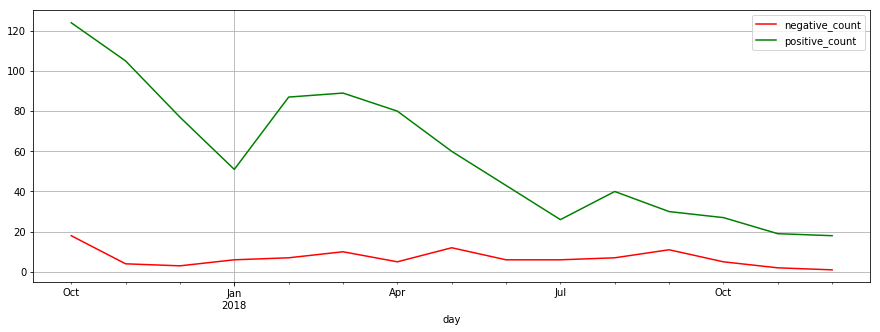

In [13]:
ai_df_vis.day = pd.to_datetime(ai_df_vis['day'], format='%Y-%m')
ai_df_vis.plot(x='day', y=['negative_count', 'positive_count'], figsize=(15,5), grid=True, color=['r', 'g'])

In [28]:
predict('i like books')['label']

'POSITIVE'

In [ ]:
ai_df_vis

In [ ]:
ax = ai_df_vis.plot(x='day', y=['negative_count', 'positive_count'], figsize=(50,5), grid=True, x_compat=True)
dates.datestr2num(date)
# set monthly locator
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

In [ ]:
# only Google news api only 6 months ago, very hard to get old news articles
from GoogleNews import GoogleNews
googlenews = GoogleNews()
googlenews.search('yunxi-technology')
googlenews.getpage(2)
googlenews.result()
ai_df['google_articles'] = np.empty((len(ai_df), 0)).tolist()